In [45]:
### No lookback
### Linear Regression
### No shuffle
### Monthly prediction

In [21]:
import sys
sys.path.append('/home/jovyan/work/')
sys.path.append('/home/jovyan/work/src')
sys.path.append('/home/jovyan/work/src/data')
sys.path.append('/home/jovyan/work/src/data_explore')
sys.path.append('/home/jovyan/work/src/features')
sys.path.append('/home/jovyan/work/src/models')
sys.path.append('/home/jovyan/work/src/analysis')


In [22]:
print(sys.path)

['/home/jovyan/work/notebooks', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/opt/conda/lib/python3.11/site-packages', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis']


In [23]:
from src import data,data_explore,features
from data import create_input_data
from data_explore import explore_util
from features import build_features
from models import train_model,predict_model
from analysis import analyze_pred

In [24]:
def get_jobs_in_range(dfq,start,end):
    df1=dfq.query('submit >= @start and submit < @end')
    return df1

In [25]:
df_arr={}
df_jan = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Jan2022_1Feb2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['jan'] = df_jan
df_feb_aug = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Feb2022_1Aug2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['feb']= get_jobs_in_range(df_feb_aug,"2022-02-01","2022-03-01")
df_arr['march']= get_jobs_in_range(df_feb_aug,"2022-03-01","2022-04-01")
df_arr['april']= get_jobs_in_range(df_feb_aug,"2022-04-01","2022-05-01")
df_arr['may'] = get_jobs_in_range(df_feb_aug,"2022-05-01","2022-06-01")
df_arr['june'] = get_jobs_in_range(df_feb_aug,"2022-06-01","2022-07-01")
df_arr['july'] = get_jobs_in_range(df_feb_aug,"2022-07-01","2022-08-01")
df_arr['august'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Aug2022_1Sept2022normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['sept'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Sept2022_1Oct2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['oct'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Oct2022_1Nov2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['nov'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Nov2022_1Dec2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['dec'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Dec2022_1Jan2023_normal_sorted.csv", parse_dates_col=[4,5,6])

In [26]:
def train_test_data(month):
    X_historydata = df_arr[month]
    ## remove default columns
    df = build_features.remove_default_cols(df_arr[month])
    Y_waittimedata = df['queue_minutes']
    X_historydata= build_features.remove_cols(df,['queue_minutes','run_minutes'])
    return X_historydata, Y_waittimedata

In [27]:
def train_model_LR(X_historydata_norm, Y_waittimedata_train):
    lreg = LinearRegression().fit(X_historydata_norm, Y_waittimedata_train)
    model_score = lreg.score(X_historydata_norm, Y_waittimedata_train) # training score
    return lreg, model_score

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def predict_evaluate(lreg,scaler,X_historydata_test,Y_waittimedata_test):
    y_pred=lreg.predict(scaler.transform(X_historydata_test))
    y_pred = np.where(y_pred<0,0,y_pred)
    r2s = r2_score(Y_waittimedata_test.to_numpy(),y_pred)
    mse = mean_squared_error(Y_waittimedata_test.to_numpy(),y_pred,squared=False)
    mae = mean_absolute_error(Y_waittimedata_test.to_numpy(),y_pred)
    return y_pred, r2s, mse, mae

In [67]:
from sklearn.linear_model import LinearRegression
from importlib import reload
import numpy as np
reload(analyze_pred)
reload(build_features)
train_months = ['jan','feb','march','april','may','june','july','august','sept','oct','nov']
predict_months = ['feb','march','april','may','june','july','august','sept','oct','nov','dec']
results=[]
for i in range(0,11):
    result = {}
    result['train_month']= train_months[i]
    result['predict_month']= predict_months[i]
    X_historydata_train, Y_waittimedata_train = train_test_data(train_months[i])
    X_historydata_test, Y_waittimedata_test = train_test_data(predict_months[i])
    X_historydata_norm, scaler = build_features.standardization(X_historydata_train)
    lreg, model_score = train_model_LR(X_historydata_norm, Y_waittimedata_train)
    y_pred, r2s, mse, mae = predict_evaluate(lreg,scaler,X_historydata_test,Y_waittimedata_test)
    ## provision_time = 20
    provision_time = 45 
    tolerance_factor = 3
    provision_time, n_scheduled, n_missed, no_missed, wrongly_scheduled, t_num = analyze_pred.analysis_short(0,Y_waittimedata_test.shape[0], Y_waittimedata_test, y_pred.ravel(),
                                                                                                          provision_time=provision_time, tolerance_factor=tolerance_factor)
    
    result['ideally_sched'] = n_scheduled
    result['missed'] = n_missed

    result['wrongly_sched'] = wrongly_scheduled
    result['total_num'] = t_num
    result['%_wrongly_sched'] = (wrongly_scheduled/t_num)*100
    result['%_ideally_sched'] = (n_scheduled/t_num)*100
    result['%_missed_oppor.'] = (n_missed/n_scheduled)*100
    result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100
    result['r2s'] = r2s
    result['mse'] = mse
    result['mae'] = mae
    result['model_score'] = model_score
    result['provision_time'] = provision_time
    #result['model'] = lreg
    result['y_pred'] = y_pred
    #result['not_missed'] = no_missed
    
    results.append(result)
    #print(result)
    #print("\n")


In [68]:
reload(analyze_pred)
rdf = analyze_pred.add_all_to_df(results)

In [69]:
rdf

,train_month,predict_month,ideally_sched,missed,wrongly_sched,total_num,%_wrongly_sched,%_ideally_sched,%_missed_oppor.,t_wrong_sched_%,r2s,mse,mae,model_score,provision_time,y_pred
0,jan,feb,12854,1683,10435,36043,28.951530,35.662958,13.093201,48.296769,0.061260,767.578353,263.695894,0.114054,45,"[207.4338791265187, 84.5816973988286, 66.24452..."
1,feb,march,16178,2236,10353,44846,23.085671,36.074566,13.821239,42.613707,0.083487,482.452983,183.937882,0.115582,45,"[113.85304079013412, 113.85304079013412, 113.5..."
2,march,april,4253,417,37866,62427,60.656447,6.812757,9.804844,90.801400,-1.198843,325.099129,213.160698,0.134397,45,"[0.0, 0.0, 363.3640318035547, 364.257204226155..."
3,april,may,1990,1291,1456,55544,2.621345,3.582745,64.874372,67.563805,0.053875,255.240565,87.577073,0.027771,45,"[0.0, 0.0, 0.0, 0.0, 43.64522555134917, 0.0, 4..."
4,may,june,7455,4086,4413,57031,7.737897,13.071838,54.808853,56.707787,0.017270,196.435443,71.493575,0.118940,45,"[121.00691702424442, 83.72954978107937, 78.256..."
5,june,july,2840,2404,550,67325,0.816933,4.218344,84.647887,55.780933,0.020874,698.904997,114.305945,0.083139,45,"[0.0, 57.697549085863194, 57.697549085863194, ..."
6,july,august,9048,309,32460,69801,46.503632,12.962565,3.415119,78.788320,0.322274,472.260650,215.594518,0.245902,45,"[231.71705789051663, 234.0192456123783, 236.32..."
7,august,sept,4056,29,20649,78908,26.168449,5.140163,0.714990,83.680499,0.171696,434.513212,166.413879,0.396366,45,"[506.2769826215984, 506.2769826215984, 0.0, 13..."
8,sept,oct,2896,109,18341,41664,44.021217,6.950845,3.763812,86.808974,-0.534437,333.251960,190.847131,0.297173,45,"[108.57818701241413, 112.80616037417408, 45.13..."
9,oct,nov,2215,673,3042,55530,5.478120,3.988835,30.383747,66.361257,0.076823,108.065318,37.788930,0.104818,45,"[111.66135710331648, 8.855573106063986, 0.0, 0..."


In [70]:
# write to file
from pathlib import Path  
filepath = Path('../data/processed/month_prediction_nolookback_LR_anon_jan22-dec22.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
rdf.to_csv(filepath,index=False)

Text(0, 0.5, 'Total Number of Wrong Scheduled Jobs')

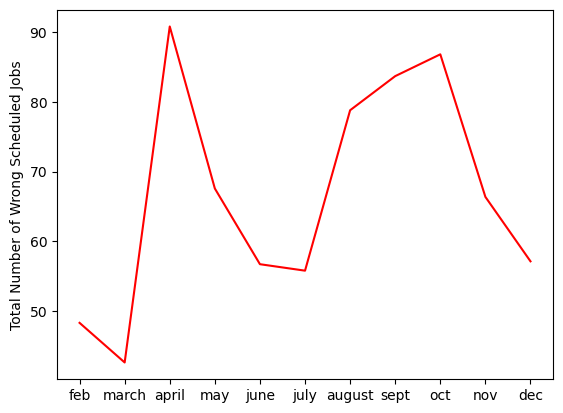

In [71]:
import matplotlib.pyplot as plt
t_wrong_sched= [] 


for i in range(0,11):
    t_wrong_sched.append(results[i]['t_wrong_sched_%'])
plt.plot(predict_months,t_wrong_sched,'r')
plt.ylabel('Total Number of Wrong Scheduled Jobs')

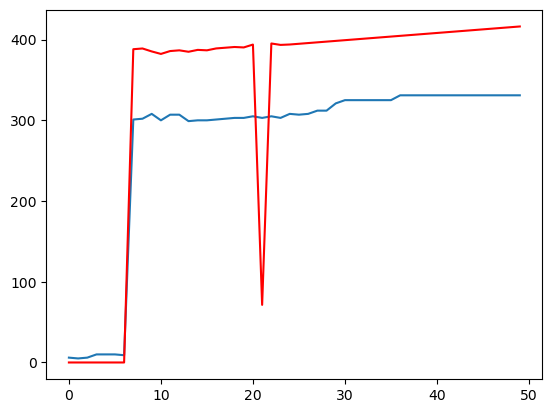

In [38]:

plt.plot(df_arr['april']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[2]['y_pred'][150:200],'r')

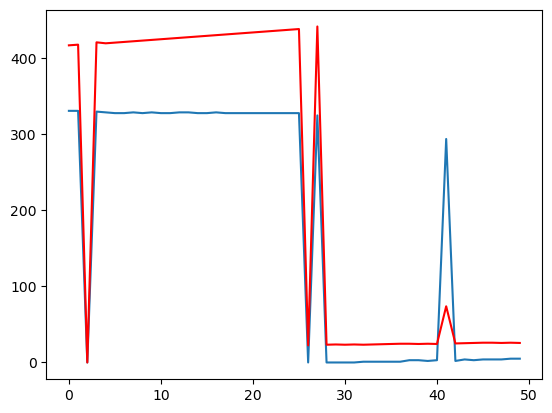

In [39]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[200:250])
plt.plot(results[2]['y_pred'][200:250],'r')

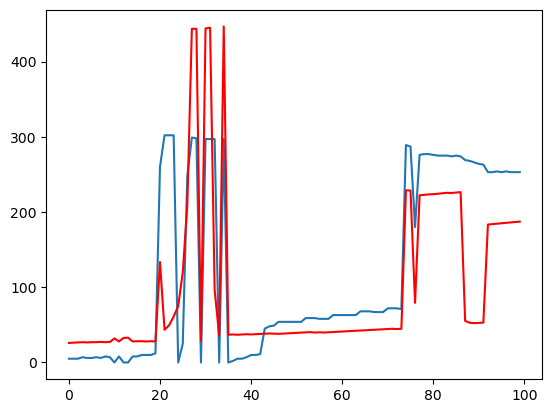

In [40]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[250:350])
plt.plot(results[2]['y_pred'][250:350],'r')

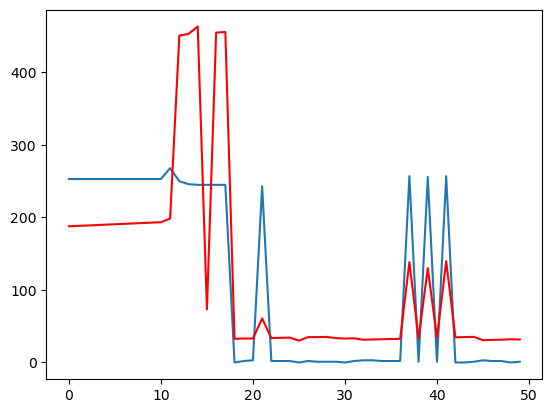

In [41]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[350:400])
plt.plot(results[2]['y_pred'][350:400],'r')

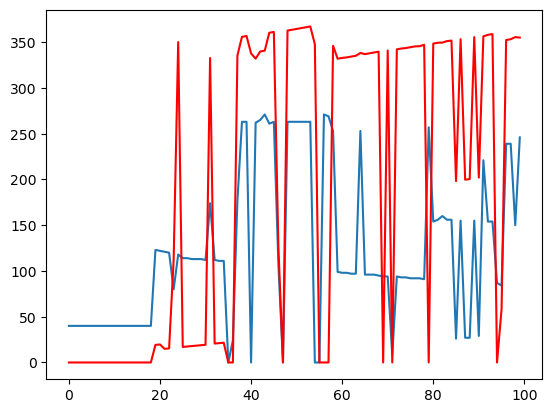

In [42]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[1250:1350])
plt.plot(results[2]['y_pred'][1250:1350],'r')

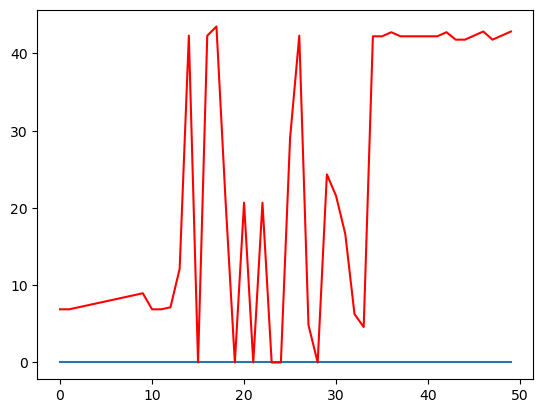

In [46]:
import matplotlib.pyplot as plt
plt.plot(df_arr['may']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[3]['y_pred'][150:200],'r')

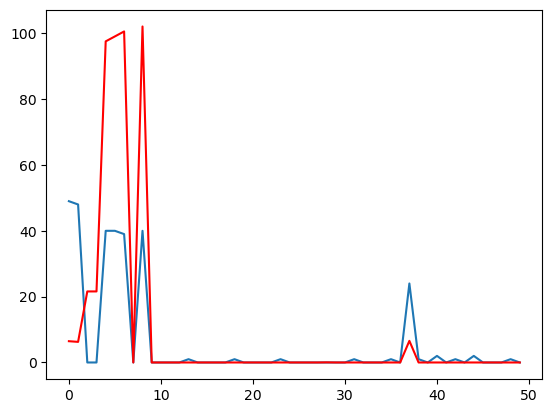

In [47]:
import matplotlib.pyplot as plt
plt.plot(df_arr['june']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[4]['y_pred'][150:200],'r')

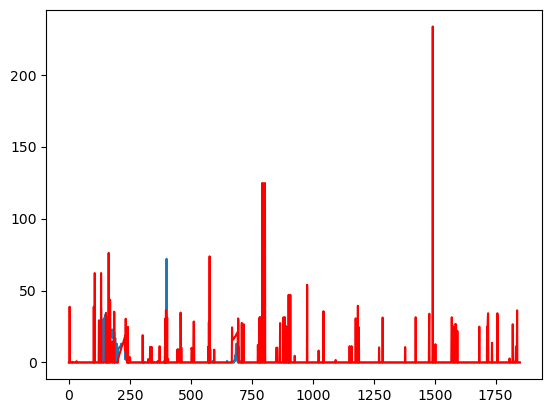

In [64]:
import matplotlib.pyplot as plt
plt.plot(df_arr['july']['queue_minutes'].to_numpy()[150:2000])
plt.plot(results[5]['y_pred'][150:2000],'r')

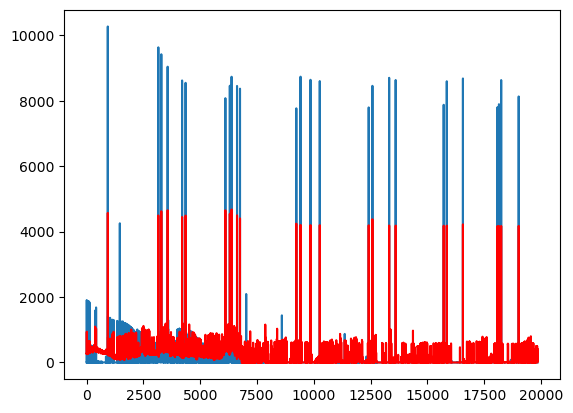

In [63]:
import matplotlib.pyplot as plt
plt.plot(df_arr['august']['queue_minutes'].to_numpy()[150:20000])
plt.plot(results[6]['y_pred'][150:20000],'r')

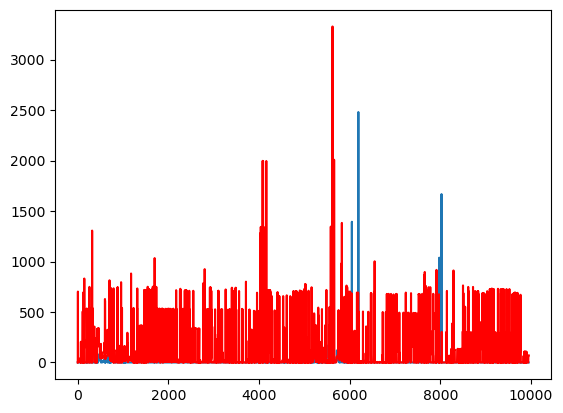

In [62]:
import matplotlib.pyplot as plt
plt.plot(df_arr['sept']['queue_minutes'].to_numpy()[50:10000])
plt.plot(results[7]['y_pred'][50:10000],'r')

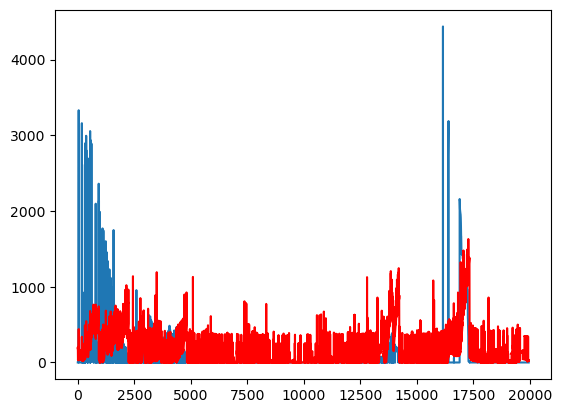

In [58]:
import matplotlib.pyplot as plt
plt.plot(df_arr['oct']['queue_minutes'].to_numpy()[50:20000])
plt.plot(results[8]['y_pred'][50:20000],'r')

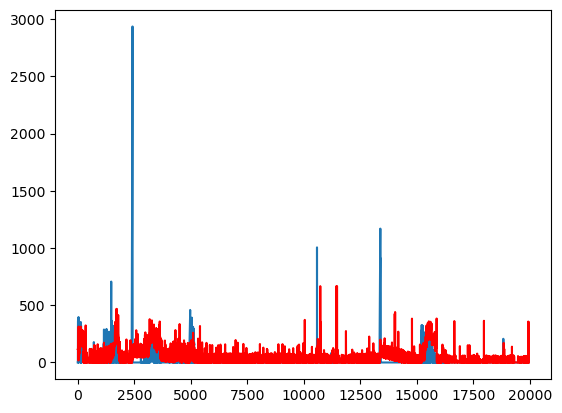

In [57]:
import matplotlib.pyplot as plt
plt.plot(df_arr['nov']['queue_minutes'].to_numpy()[50:20000])
plt.plot(results[9]['y_pred'][50:20000],'r')

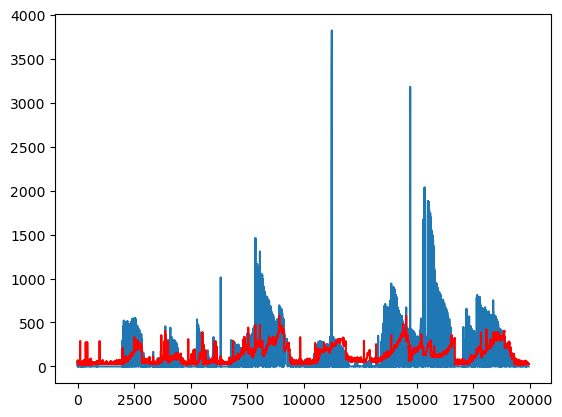

In [56]:
import matplotlib.pyplot as plt
plt.plot(df_arr['dec']['queue_minutes'].to_numpy()[50:20000])
plt.plot(results[10]['y_pred'][50:20000],'r')

In [29]:
from sklearn import linear_model
alpha_list = [0.00001,0.0001, 0.001, 0.005,0.01, 0.025, 0.05,0.1, 0.5,1, 1.5,2,5]
pred=[]
for alpha in alpha_list:
    clf = linear_model.Lasso(alpha)
    clf.fit(X_historydata_norm,Y_waittimedata_train)
    y_pred3 = clf.predict(scaler.transform(X_historydata_test))
    #dis = np.linalg.norm(y_pred3-Y_waittimedata_test)
    score = clf.score(X_historydata_norm,Y_waittimedata_train)
    pred.append(score)
    print("alpha: " + str(alpha) + " score: " + str(score))
    print("coefficients: " + str(clf.coef_))

alpha: 1e-05 score: 0.15055777192734532
coefficients: [1259.29533719  181.89957571  412.53005077  326.95756577   78.17413341
 -217.05857691  102.0698538   106.42995386  823.49652068  -25.8302958
 -202.42857618   70.44905082 -443.90831659  600.31653789   82.63488198
  -41.26535236 -164.84239664  446.96611493 -217.69600671 -121.77145131
  164.3136722   147.58830623 -136.8719604  -136.23428418  178.75038215
 -299.4255282    39.30998659  123.58797808    2.51498085 -177.44946075
   89.15737264  192.55514429 -168.32194664  -40.91525132  441.00426946
   -7.14151301  -31.84663995  -61.99765465   79.77187515   50.84894414
   47.56140217 -175.86440199]
alpha: 0.0001 score: 0.15055777080921795
coefficients: [1259.0606489   181.93380756  412.52972799  326.95874789   78.17100144
 -217.03651388  102.04929995  106.42149005  823.40063253  -25.72242134
 -202.36366049   70.34045707 -443.78877315  600.23378193   82.54656759
  -41.18075302 -164.75635204  446.82912401 -217.63449719 -121.69376825
  164.2844